In [4]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

# Import relevant libraries
import numpy as np
from numpy import asarray
from PIL import Image
import os

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
# from kt_utils import *
from keras.losses import BinaryCrossentropy

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

In [6]:
directory = 'faces'
ls = []
i = 0
for filename in os.listdir(directory)[:300]:
    i += 1
    if (i % 1000 == 0):
        print(i)
    img = Image.open('faces/' + filename)
    data = asarray(img)
    ls.append(data)

In [7]:
imgs_train = np.array(ls[:100])
imgs_test = np.array(ls[200:250])
print(imgs_test.shape)

label_train = np.array([np.ones((100), dtype=int)])
label_test = np.array([np.ones((50), dtype=int)])

(50, 256, 256, 3)


In [ ]:
# Escrever no ficheiro
with open('formatted_imgs.txt', 'w') as f:
    
    # OPÇAO 1
    f.write(str(ls))
    
    # OPÇAO 2
    for i in ls[:-1]:
       f.write(str(i) + ',\n')
    f.write(str(ls[-1]) + '\n')  
    
f.close()

In [8]:


# Normalize image vectors
imgs_train_norm = imgs_train / 255.
imgs_test_norm = imgs_test / 255.

# Reshape
label_train_T = label_train.T
label_test_T = label_test.T

print ("number of training examples = " + str(imgs_train_norm.shape[0]))
print ("number of testing examples = " + str(imgs_test_norm.shape[0]))
print ("X_train shape: " + str(imgs_train_norm.shape))
print ("Y_train shape: " + str(label_train_T.shape))
print ("X_train shape: " + str(imgs_test_norm.shape))
print ("Y_train shape: " + str(label_test_T.shape))

number of training examples = 100
number of testing examples = 50
X_train shape: (100, 256, 256, 3)
Y_train shape: (100, 1)
X_train shape: (50, 256, 256, 3)
Y_train shape: (50, 1)


In [9]:
# HappyModel

def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    # Use the suggested model in the text above to get started, and run through the whole
    # exercise once. Then come back and add more BLOCKS. 
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)
    
    # BLOCK 1: CONV -> BN -> RELU -> MAXP
    num_filters = 32
    kernel_size = (7, 7)
    stride = (1, 1)
    X = Conv2D(num_filters, kernel_size, strides = stride, name = 'conv0')(X)

    # BLOCK 2: CONV -> BN -> RELU -> MAXP
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
        
    # BLOCK 3: CONV -> BN -> RELU -> MAXP
    X = Activation('relu')(X)
    
    # BLOCK 4: CONV -> BN -> RELU -> MAXP
    max_pool_size = (2, 2)
    X = MaxPooling2D(max_pool_size, name='max_pool')(X)
       
        
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model

In [10]:
happyModel = HappyModel(imgs_train.shape[1:])

In [11]:
happyModel.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=["accuracy"])

In [13]:
happyModel.fit(x = imgs_test_norm, y = label_test_T, batch_size = 32, epochs = 4)

Epoch 1/4
2/2 [==============================] - 4s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2/4
2/2 [==============================] - 4s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/4
2/2 [==============================] - 4s 1s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/4
2/2 [==============================] - 4s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000


In [14]:
happyModel.summary()

Model: "HappyModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 262, 262, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 256, 256, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 256, 256, 32)      128       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pool (MaxPooling2D)     (None, 128, 128, 32)      0         
                                                        

In [15]:
preds = happyModel.evaluate(x = imgs_train_norm, y = label_train_T)

print()
print ("Loss = " + str(preds[0]))
print ("Train Accuracy = " + str(preds[1]))

4/4 [==============================] - 2s 370ms/step - loss: 6.4541e-24 - accuracy: 1.0000

Loss = 6.4540651016352555e-24
Train Accuracy = 1.0


In [16]:
preds = happyModel.evaluate(x = imgs_test_norm, y = label_test_T)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

2/2 [==============================] - 1s 331ms/step - loss: 6.7612e-35 - accuracy: 1.0000

Loss = 6.761180626822045e-35
Test Accuracy = 1.0


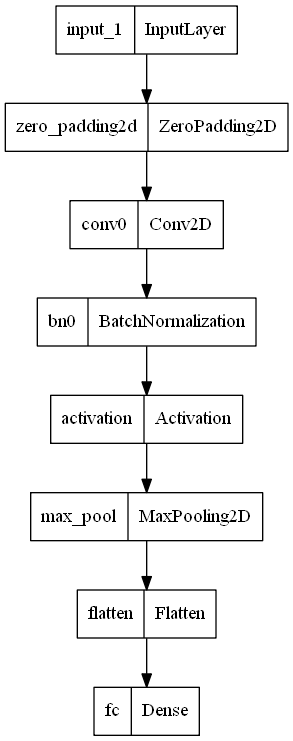

In [17]:
# plots the model in a nice layout and save it as ".png"
plot_model(happyModel, to_file='HappyModel.png')

ValueError: in user code:

    File "D:\Programas\anaconda3\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "D:\Programas\anaconda3\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Programas\anaconda3\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "D:\Programas\anaconda3\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "D:\Programas\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\Programas\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "HappyModel" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 1024, 1024, 3)


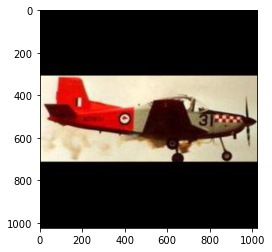

In [25]:
img_path = 'no_faces/0_2.jpg'
img = image.load_img(img_path, target_size=(256, 256))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(happyModel.predict(x))